## Using TorchScript Model

In [ ]:
import torch

# Load the TorchScript model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = torch.jit.load("cgan_generator_scripted.pt", map_location=device)
generator.eval()  # Set to evaluation mode

print("✅ TorchScript model loaded successfully!")


✅ TorchScript model loaded successfully!


In [ ]:
# CIFAR-10 Classes
cifar10_classes = ["airplane", "automobile", "bird", "cat", "deer", 
                   "dog", "frog", "horse", "ship", "truck"]

# Function to find the closest CIFAR-10 class
def map_to_cifar10(text_command):
    for cls in cifar10_classes:
        if cls in text_command:
            return cifar10_classes.index(cls), cls  # Return index & class name
    return None, None  # No match found

# Example usage with speech input
text_command = "dog"  # Replace with transcribed text from Whisper
label_index, label_name = map_to_cifar10(text_command)

if label_name:
    print(f"🎯 Mapped Class: {label_name} ({label_index})")
else:
    print("⚠️ No valid CIFAR-10 class detected!")


🎯 Mapped Class: dog (5)


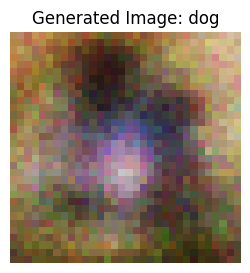

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Function to generate an image using the loaded TorchScript model
def generate_from_voice(generator, label_index, label_name):
    if label_index is None:
        print("⚠️ No valid image can be generated.")
        return

    # Generate random noise
    noise_dim = 100  # Assuming the generator expects 100-dimensional noise
    noise = torch.randn(1, noise_dim).to(device)
    
    # Convert label to tensor
    label = torch.tensor([label_index]).to(device)

    # Generate the image
    with torch.no_grad():
        fake_img = generator(noise, label)
    
    # Unnormalize and display the image
    fake_img = (fake_img + 1) / 2  # Scale from [-1,1] to [0,1]
    
    plt.figure(figsize=(3,3))
    plt.imshow(np.transpose(fake_img[0].cpu().numpy(), (1, 2, 0)))
    plt.axis("off")
    plt.title(f"Generated Image: {label_name}")
    plt.show()

# Generate image from transcribed speech
generate_from_voice(generator, label_index, label_name)


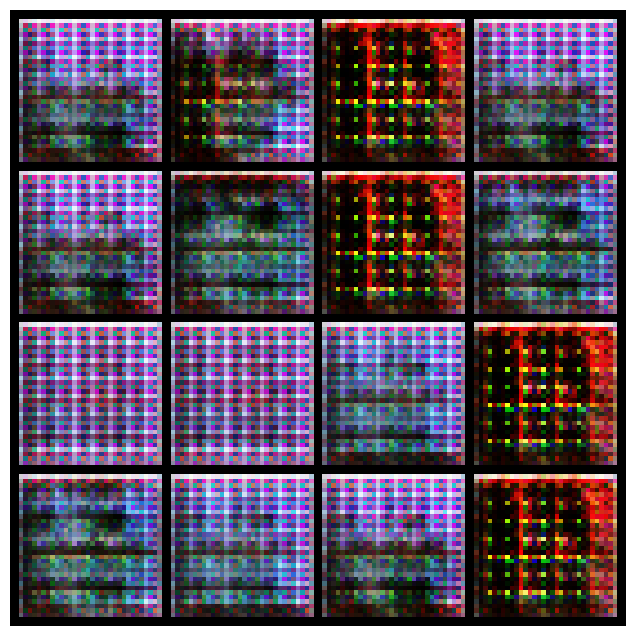

In [7]:
import torch
import torch.nn as nn
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np

# Define the Generator class with noise_dim = 200
class Generator(nn.Module):
    def __init__(self, noise_dim, num_classes, img_channels=3):
        super(Generator, self).__init__()
        self.label_embedding = nn.Embedding(num_classes, noise_dim)  # Embed labels
        self.model = nn.Sequential(
            nn.Linear(noise_dim * 2, 512 * 2 * 2),  # Adjusted projection size
            nn.BatchNorm1d(512 * 2 * 2),
            nn.ReLU(True),
            nn.Unflatten(1, (512, 2, 2)),  # Reshape to CNN input (512x2x2)

            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, img_channels, kernel_size=4, stride=2, padding=1),  # Output 32x32 image
            nn.Tanh()  # Normalize to [-1,1]
        )

    def forward(self, noise, labels):
        label_embedding = self.label_embedding(labels)  # Convert label to embedding
        x = torch.cat([noise, label_embedding], dim=1)  # Concatenate noise & label
        img = self.model(x)
        return img  # Output shape: (batch, 3, 32, 32)

# Load the trained generator model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define model parameters (must match training configuration)
noise_dim = 200  # Set noise_dim to 200 to match the checkpoint
num_classes = 10  # Number of classes (e.g., 10 for MNIST)
img_channels = 3  # Number of image channels (e.g., 3 for RGB)

# Initialize the generator
generator = Generator(noise_dim, num_classes, img_channels).to(device)

# Load the trained weights
generator.load_state_dict(torch.load("generator.pth", map_location=device))
generator.eval()  # Set to evaluation mode

# Function to generate images
def generate_images(num_images, labels):
    # Create noise vectors
    noise = torch.randn(num_images, noise_dim, device=device)  # Random noise
    labels = torch.tensor(labels, device=device)  # Convert labels to tensor
    # Generate images
    with torch.no_grad():
        fake_images = generator(noise, labels).detach().cpu()
    return fake_images

# Example usage
num_images = 16  # Number of images to generate
labels = np.random.randint(0, num_classes, num_images)  # Random labels for each image
fake_images = generate_images(num_images, labels)

# Display the generated images
fake_images = (fake_images + 1) / 2  # Rescale images from [-1, 1] to [0, 1]
grid = vutils.make_grid(fake_images, nrow=4, padding=2, normalize=False)
plt.figure(figsize=(8, 8))
plt.imshow(np.transpose(grid, (1, 2, 0)))
plt.axis("off")
plt.show()

In [2]:
checkpoint = torch.load("generator.pth", map_location=device)
for key, value in checkpoint.items():
    print(f"{key}: {value.shape}")



label_embedding.weight: torch.Size([10, 200])
model.0.weight: torch.Size([2048, 400])
model.0.bias: torch.Size([2048])
model.1.weight: torch.Size([2048])
model.1.bias: torch.Size([2048])
model.1.running_mean: torch.Size([2048])
model.1.running_var: torch.Size([2048])
model.1.num_batches_tracked: torch.Size([])
model.4.weight: torch.Size([512, 256, 4, 4])
model.4.bias: torch.Size([256])
model.5.weight: torch.Size([256])
model.5.bias: torch.Size([256])
model.5.running_mean: torch.Size([256])
model.5.running_var: torch.Size([256])
model.5.num_batches_tracked: torch.Size([])
model.7.weight: torch.Size([256, 128, 4, 4])
model.7.bias: torch.Size([128])
model.8.weight: torch.Size([128])
model.8.bias: torch.Size([128])
model.8.running_mean: torch.Size([128])
model.8.running_var: torch.Size([128])
model.8.num_batches_tracked: torch.Size([])
model.10.weight: torch.Size([128, 64, 4, 4])
model.10.bias: torch.Size([64])
model.11.weight: torch.Size([64])
model.11.bias: torch.Size([64])
model.11.runn